In [1]:
import torch
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering

In [ ]:
data = pd.read_excel("datatouse.xlsx")

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [ ]:
def encode_text(texts):
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=512)
    with torch.no_grad():
        outputs = model(**encoded_input)
    return outputs.last_hidden_state.mean(dim=1).numpy()

In [ ]:
def decompose_query(query):
    return query.split(",")

In [9]:
# Calculate similarity between clinical features and nodes in the Knowledge Graph
def clinical_features_matching(features, knowledge_graph_nodes):
    feature_embeddings = encode_text(features)
    kg_embeddings = encode_text(knowledge_graph_nodes)
    similarities = cosine_similarity(feature_embeddings, kg_embeddings)
    return similarities

In [10]:
# Apply the indicator function to filter out irrelevant matches
def apply_indicator_function(similarities, threshold=0.7):
    valid_matches = (similarities > threshold).astype(int)
    return valid_matches

In [11]:
# Retrieve top-m most relevant matches
def retrieve_top_matches(similarities, m=3):
    top_matches = []
    for i in range(similarities.shape[0]):
        sorted_indices = np.argsort(similarities[i])[::-1]  # Sort by similarity in descending order
        top_m = sorted_indices[:m]
        top_matches.append(top_m)
    return top_matches

In [12]:
# Agglomerative Clustering (Hierarchical Clustering)
def agglomerative_clustering(data, num_clusters=8):
    embeddings = encode_text(data['object'].tolist())
    agg_clust = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward')
    data['cluster'] = agg_clust.fit_predict(embeddings)
    return data, agg_clust

In [13]:
# Hierarchical aggregation (simple categorization based on clusters)
def hierarchical_aggregation(cluster_id):
    if cluster_id in [0, 1]:
        return 'Respiratory Diseases'
    else:
        return 'Cardiovascular Diseases'

In [14]:
# Create Disease Knowledge Graph
def create_disease_knowledge_graph(data):
    G = nx.Graph()
    for idx, row in data.iterrows():
        G.add_node(row['subject'], cluster=row['cluster'], description=row['object'])
    for cluster_id in range(num_clusters):
        cluster_nodes = data[data['cluster'] == cluster_id]['subject'].tolist()
        for i in range(len(cluster_nodes)):
            for j in range(i + 1, len(cluster_nodes)):
                G.add_edge(cluster_nodes[i], cluster_nodes[j])
    return G

In [15]:
# Upward Traversal (for finding closest disease subcategory)
def upward_traversal(ti, eL2j, graph):
    # This is a placeholder for actual traversal code
    return 0.85  # Return a dummy value representing the similarity

In [16]:
# Closest Disease Subcategory
def find_closest_disease_subcategory(ti, eL2j_candidates, graph, threshold=0.7):
    votes = {eL2j: 0 for eL2j in eL2j_candidates}
    for eL2j in eL2j_candidates:
        similarity = upward_traversal(ti, eL2j, graph)
        if similarity > threshold:
            votes[eL2j] += 1
    eL2s = max(votes, key=votes.get)
    return eL2s

In [17]:
# Diagnostic Differences Knowledge Graph (K(eL2s))
def construct_diagnostic_differences_graph(graph, eL2s):
    K = set()
    neighbors = list(graph.neighbors(eL2s))
    for neighbor in neighbors:
        for subneighbor in graph.neighbors(neighbor):
            K.add((neighbor, subneighbor))
    return K

In [18]:
# Visualize Disease Knowledge Graph
def visualize_disease_knowledge_graph(G):
    node_colors = [data.loc[data['subject'] == node, 'cluster'].values[0] for node in G.nodes]
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    nx.draw(G, pos, with_labels=True, node_size=1000, node_color=node_colors, cmap=plt.cm.viridis, font_size=10, font_weight='bold')
    plt.title("Disease Knowledge Graph (Disease Clustering) - Agglomerative Clustering")
    plt.show()

In [ ]:
def match_query_to_kg_and_visualize(query, G, threshold=0.7, top_m=3):
    features = decompose_query(query)
    
    knowledge_graph_nodes = list(G.nodes)
    
    # Clinical Features Matching
    similarities = clinical_features_matching(features, knowledge_graph_nodes)
    valid_matches = apply_indicator_function(similarities, threshold)
    top_matches = retrieve_top_matches(similarities * valid_matches, m=top_m)

    print("Top matching clinical features in the knowledge graph:")
    for match in top_matches:
        print(match)
    
    # Closest Disease Subcategory
    closest_subcategory = find_closest_disease_subcategory(features[0], knowledge_graph_nodes, G)
    print(f"\nClosest Disease Subcategory: {closest_subcategory}")

    # Diagnostic Differences Knowledge Graph
    diagnostic_graph = construct_diagnostic_differences_graph(G, closest_subcategory)
    print(f"\nDiagnostic Differences Knowledge Graph (K({closest_subcategory})): {diagnostic_graph}")

    visualize_disease_knowledge_graph(G)
    

Top matching clinical features in the knowledge graph:
[62 15 28 27 26]
[10 62 15 28 27]
[62 15 28 27 26]

Closest Disease Subcategory: acute_copd_exacerbation_infection

Diagnostic Differences Knowledge Graph (K(acute_copd_exacerbation_infection)): {('unstable_angina', 'ebola'), ('atrial_fibrillation', 'anemia'), ('acute_rhinosinusitis', 'myocarditis'), ('sarcoidosis', 'allergic_sinusitis'), ('atrial_fibrillation', 'anaphylaxis'), ('pancreatic_neoplasm', 'guillain_barre_syndrome'), ('autoimmune_and_immunological_diseases', 'myocarditis'), ('unstable_angina', 'boerhaave_syndrome'), ('gerd', 'myocarditis'), ('pericarditis', 'allergic_sinusitis'), ('myocarditis', 'bronchiolitis'), ('pulmonary_neoplasm', 'acute_laryngitis'), ('acute_laryngitis', 'panic_attack'), ('acute_copd_exacerbation_infection', 'acute_pulmonary_edema'), ('autoimmune_and_immunological_diseases', 'psvt'), ('spontaneous_rib_fracture', 'acute_copd_exacerbation_infection'), ('pancreatic_neoplasm', 'gastrointestinal_system

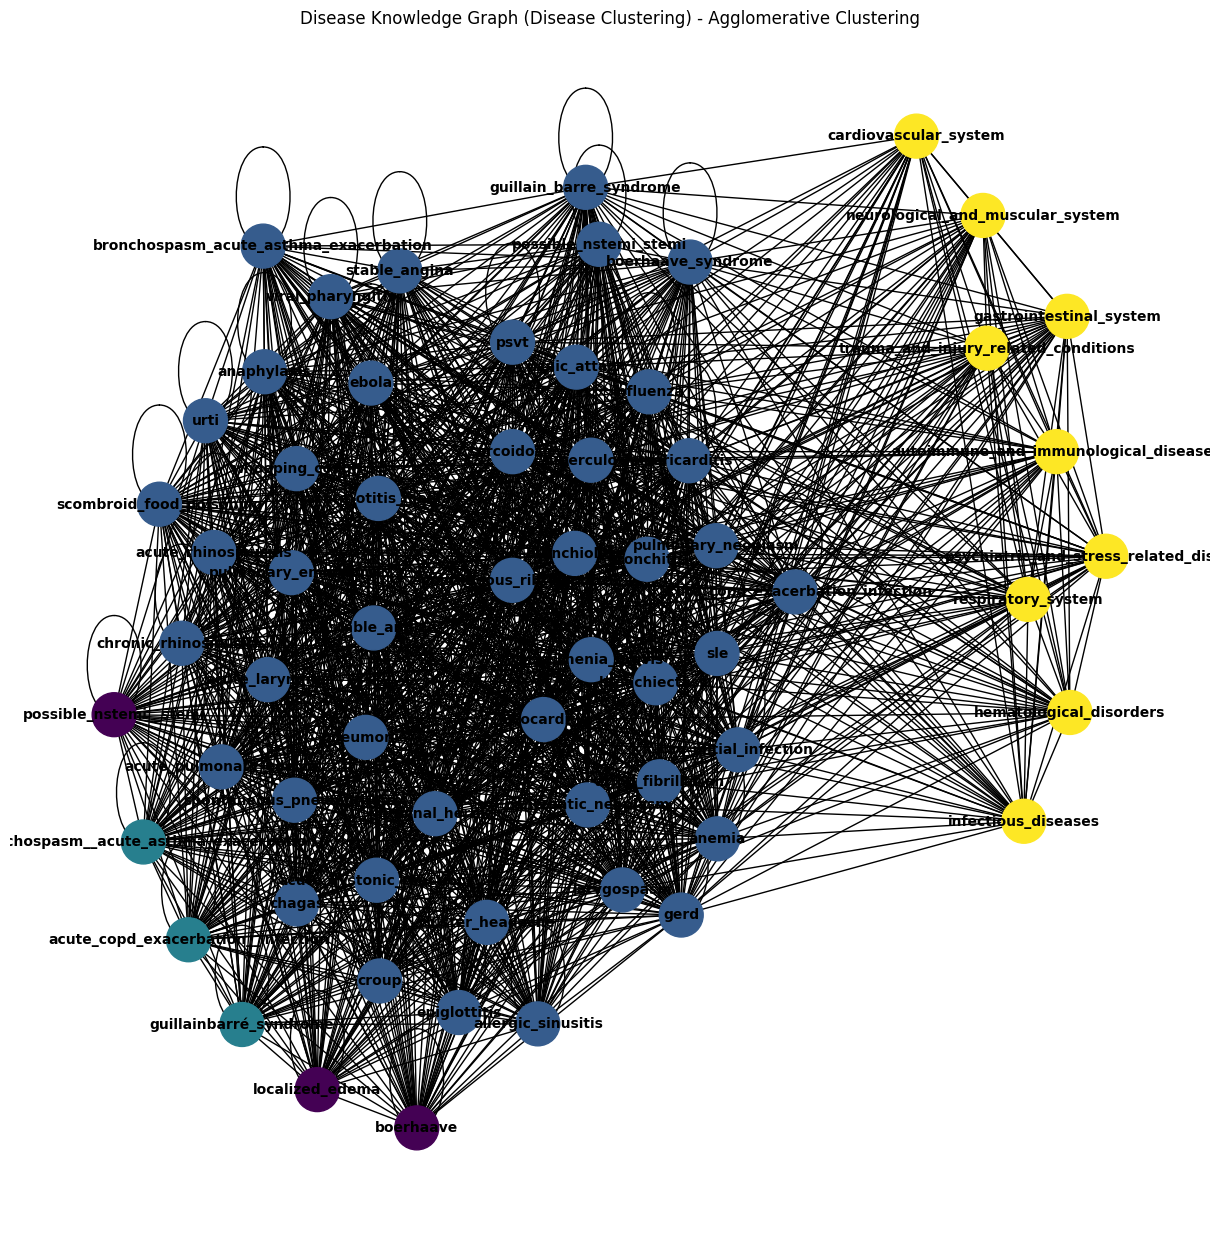

In [23]:
query = "shortness of breath, cough, wheezing"

num_clusters = 8
data, agg_clust = agglomerative_clustering(data, num_clusters=num_clusters) 

G = create_disease_knowledge_graph(data) 

match_query_to_kg_and_visualize(query, G, threshold=0.7, top_m=5)


In [21]:
def map_indices_to_names(top_matches, knowledge_graph_nodes):
    matched_names = []
    for match in top_matches:
        matched_names.append([knowledge_graph_nodes[i] for i in match])  
    return matched_names

query = "shortness of breath, cough, wheezing" 
knowledge_graph_nodes = list(G.nodes)  
similarities = clinical_features_matching(decompose_query(query), knowledge_graph_nodes)
valid_matches = apply_indicator_function(similarities, threshold=0.7)
top_matches = retrieve_top_matches(similarities * valid_matches, m=3)  

matched_names = map_indices_to_names(top_matches, list(G.nodes))

# The system retrueves n x m mathcing nodes in the G (Disease Knowledge Graph   )
print("Top matching clinical features in the knowledge graph:")
for match in matched_names:
    print(match)

Top matching clinical features in the knowledge graph:
['guillainbarré_syndrome', 'epiglottitis', 'sle']
['whooping_cough', 'guillainbarré_syndrome', 'epiglottitis']
['guillainbarré_syndrome', 'epiglottitis', 'sle']
